In [38]:
# reference : https://github.com/keras-team/keras-io/blob/master/examples/graph/ipynb/gnn_citations.ipynb

In [39]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
# Dataset - Cora
# The dataset has two tap-separated files: cora.cites and cora.content.
# (i)The cora.cites includes the citation records with two columns: 
#    cited_paper_id (target) and citing_paper_id (source).
# (ii)The cora.content includes the paper content records 
#     with 1,435 columns: paper_id, subject, and 1,433 binary features.

In [41]:
# get dataset
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [42]:
# Data exploration

In [43]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [44]:
citations.sample(frac=1).head()

#The target column includes the paper ids cited by the paper ids 
#in the source column

,target,source
3868,93318,1126050
3144,45189,976284
3133,45188,192734
3638,75121,417017
1755,11335,1153264


In [45]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [46]:
print(papers.sample(5).T)

# The DataFrame includes the paper_id and the subject columns, 
# as well as 1,433 binary column representing whether a term exists 
# in the paper or not.

                    1007        2544        1640    2560                2152
paper_id           72908       28267       95188   10186              593155
term_0                 0           0           0       0                   0
term_1                 1           0           0       0                   0
term_2                 0           0           0       0                   0
term_3                 0           0           0       0                   0
...                  ...         ...         ...     ...                 ...
term_1429              0           0           0       0                   0
term_1430              0           0           0       0                   0
term_1431              0           0           0       0                   0
term_1432              0           0           0       0                   0
subject    Rule_Learning  Case_Based  Case_Based  Theory  Genetic_Algorithms

[1435 rows x 5 columns]


In [47]:
print(papers.subject.value_counts())

# 7 classes/subjects and count of papers in each subject

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [48]:
# convert to zero based indices
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

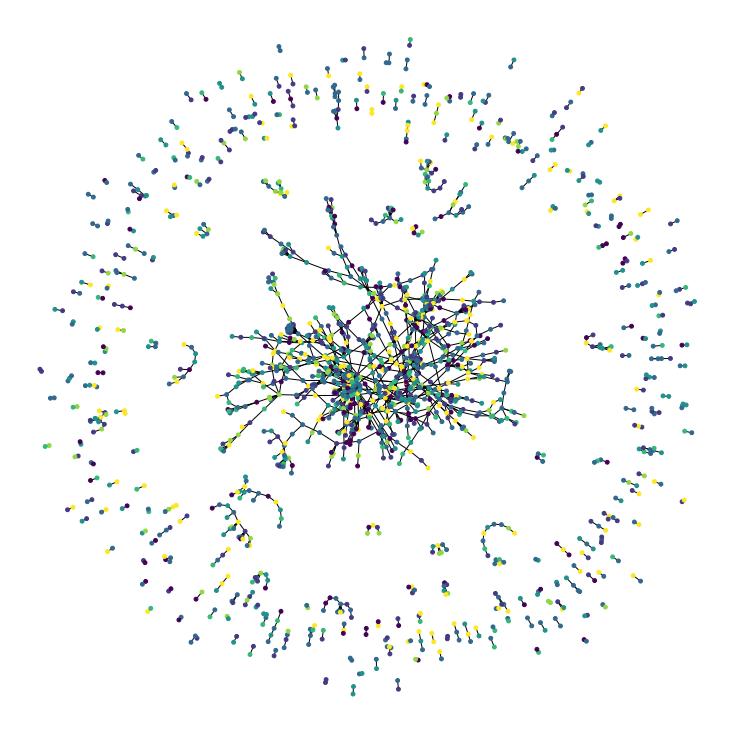

In [49]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

# each node is a paper, each color designates a specific subject

In [50]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1352, 1435)
Test data shape: (1356, 1435)


In [51]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [52]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    # Optimizer - Adam
    # loss criterion - Sparse Categorical Cross entropy
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [53]:
# helper function to visualize
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [54]:
# This feed forward nn is used in the baseline and the GNN models
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [55]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [56]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [57]:
#Train the baseline model

history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 2s 62ms/step - loss: 3.4420 - acc: 0.1889 - val_loss: 1.8853 - val_acc: 0.2463
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 2.7056 - acc: 0.2289 - val_loss: 1.8982 - val_acc: 0.1330
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 2.3303 - acc: 0.2559 - val_loss: 1.8882 - val_acc: 0.2069
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 2.1305 - acc: 0.2776 - val_loss: 1.8673 - val_acc: 0.2611
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 1.9884 - acc: 0.2855 - val_loss: 1.8573 - val_acc: 0.2611
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 1.9129 - acc: 0.3029 - val_loss: 1.8527 - val_acc: 0.2759
Epoch 7/300
5/5 [==============================] - 0s 9ms/step - loss: 1.8288 - acc: 0.3246 - val_loss: 1.8405 - val_acc: 0.3350
Epoch 8/300
5/5 [==============================] - 0s 12ms/step - loss: 1.7593 - acc: 0.3316 

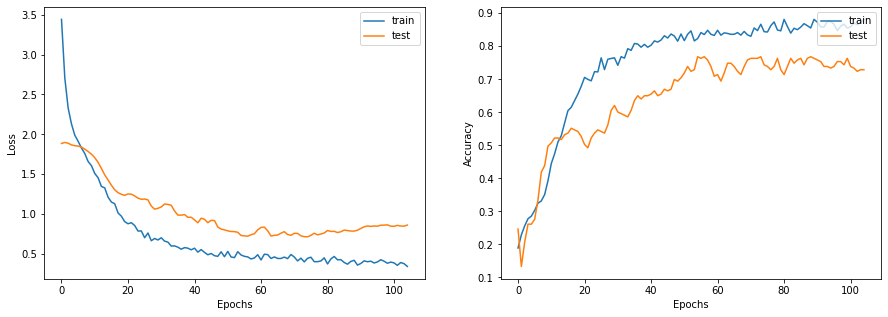

In [58]:
display_learning_curves(history)

In [59]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.67%


In [60]:
# used to create new instances for testing the baseline model
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [61]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 43.41%
- Genetic_Algorithms: 24.39%
- Neural_Networks: 17.99%
- Probabilistic_Methods: 5.2%
- Reinforcement_Learning: 6.68%
- Rule_Learning: 0.68%
- Theory: 1.64%
Instance 2:
- Case_Based: 16.33%
- Genetic_Algorithms: 8.91%
- Neural_Networks: 3.41%
- Probabilistic_Methods: 2.31%
- Reinforcement_Learning: 66.71%
- Rule_Learning: 0.55%
- Theory: 1.79%
Instance 3:
- Case_Based: 0.42%
- Genetic_Algorithms: 0.61%
- Neural_Networks: 90.63%
- Probabilistic_Methods: 7.94%
- Reinforcement_Learning: 0.15%
- Rule_Learning: 0.11%
- Theory: 0.15%
Instance 4:
- Case_Based: 2.63%
- Genetic_Algorithms: 0.35%
- Neural_Networks: 88.61%
- Probabilistic_Methods: 8.1%
- Reinforcement_Learning: 0.06%
- Rule_Learning: 0.1%
- Theory: 0.14%
Instance 5:
- Case_Based: 1.12%
- Genetic_Algorithms: 4.01%
- Neural_Networks: 38.23%
- Probabilistic_Methods: 6.39%
- Reinforcement_Learning: 49.02%
- Rule_Learning: 0.14%
- Theory: 1.1%
Instance 6:
- Case_Based: 4.29%
- Genetic_Algorithms: 0.58%


In [62]:
# Graph preparation for loading into a GNN is hard
# Below approach assumes entire graph fits in memory - 

In [63]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T

# Create an edge weights array of ones. - not used here since the citations are not weighted
edge_weights = tf.ones(shape=edges.shape[1])

# Create a node features array of shape [num_nodes, num_features]. 
# Nodes are the papers and node_features word presence binary vectors for each paper
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [64]:
# The GNN
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    # input node representations are processed using a FFN to produce a message        
    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    # messages of the neighbours of each node are aggregated using operations such as sum,mean,max
    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    # node representations and aggregated messages are updated on the current node to produce a new state of current node
    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [65]:
# The classifier
# Approach : reference : https://arxiv.org/abs/2011.08843 (Design Space for GNN)
# Apply preprocessing using FFN to the node features to generate initial node representations.
# Apply one or more graph convolutional layer, with skip connections, to the node representation to produce node embeddings.
# Apply post-processing using FFN to the node embeddings to generat the final node embeddings.
# Feed the node embeddings in a Softmax layer to predict the node class.

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.squeeze(tf.gather(x, input_node_indices))
        # Compute logits
        return self.compute_logits(node_embeddings)

In [66]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.12478883  0.06827824  0.00569584  0.04651588  0.10106459 -0.0179675
   0.00440884]
 [ 0.1526248   0.08150469 -0.02210883  0.05207757  0.05290908 -0.0353277
  -0.01173693]
 [-0.01132255 -0.06058659 -0.04699261 -0.09355921  0.00654763  0.04063996
  -0.04194726]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (2708, 32)                52804     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (2708, 32)                2368      
______________________________________________________________

In [67]:
#Train the GNN model

x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 3s 131ms/step - loss: 2.0872 - acc: 0.2071 - val_loss: 1.9141 - val_acc: 0.3103
Epoch 2/300
5/5 [==============================] - 0s 65ms/step - loss: 1.9621 - acc: 0.2846 - val_loss: 1.8930 - val_acc: 0.3005
Epoch 3/300
5/5 [==============================] - 0s 68ms/step - loss: 1.8856 - acc: 0.2785 - val_loss: 1.8887 - val_acc: 0.3005
Epoch 4/300
5/5 [==============================] - 0s 61ms/step - loss: 1.8534 - acc: 0.2820 - val_loss: 1.8839 - val_acc: 0.3005
Epoch 5/300
5/5 [==============================] - 0s 65ms/step - loss: 1.8682 - acc: 0.2855 - val_loss: 1.8742 - val_acc: 0.3005
Epoch 6/300
5/5 [==============================] - 0s 61ms/step - loss: 1.8388 - acc: 0.3090 - val_loss: 1.8610 - val_acc: 0.3005
Epoch 7/300
5/5 [==============================] - 0s 70ms/step - loss: 1.8183 - acc: 0.3133 - val_loss: 1.8534 - val_acc: 0.3005
Epoch 8/300
5/5 [==============================] - 0s 68ms/step - loss: 1.8303 - acc: 0.3

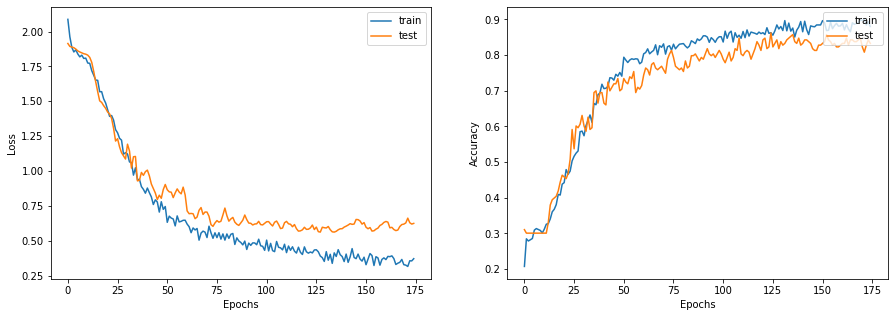

In [68]:
display_learning_curves(history)

In [69]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 79.87%


In [70]:
# Add new instances to test GNN model against these

# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [71]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
Instance 1:
- Case_Based: 1.01%
- Genetic_Algorithms: 98.01%
- Neural_Networks: 0.53%
- Probabilistic_Methods: 0.11%
- Reinforcement_Learning: 0.28%
- Rule_Learning: 0.03%
- Theory: 0.04%
Instance 2:
- Case_Based: 0.12%
- Genetic_Algorithms: 57.5%
- Neural_Networks: 0.4%
- Probabilistic_Methods: 0.04%
- Reinforcement_Learning: 41.83%
- Rule_Learning: 0.0%
- Theory: 0.1%
Instance 3:
- Case_Based: 0.03%
- Genetic_Algorithms: 0.04%
- Neural_Networks: 99.51%
- Probabilistic_Methods: 0.13%
- Reinforcement_Learning: 0.21%
- Rule_Learning: 0.02%
- Theory: 0.07%
Instance 4:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.01%
- Neural_Networks: 99.82%
- Probabilistic_Methods: 0.11%
- Reinforcement_Learning: 0.05%
- Rule_Learning: 0.0%
- Theory: 0.01%
Instance 5:
- Case_Based: 0.18%
- Genetic_Algorithms: 6.31%
- Neural_Networks: 54.32%
- Probabilistic_Methods: 1.